In [49]:
# Importing Required Libraries
import numpy as np
import numpy.random as npr
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [48]:
from shap import TreeExplainer, KernelExplainer, Explainer
from convection_param.shap_values.ShapMultiOutputRegressor import MultiOutputTreeExplainer, build_tree_explainer
from tqdm.auto import tqdm

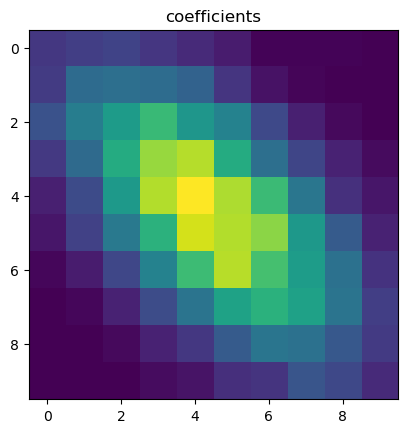

((100000, 10), (100000, 10))

In [121]:
npr.seed(10)
X = npr.multivariate_normal(np.zeros(10), np.eye(10), size=int(1e5))

scatter = npr.multivariate_normal(mean=np.zeros(2), cov=[[1,0.6],[0.6,1]], size=10000)
# plt.scatter(scatter[:,0], scatter[:,1], s=1)
hist = np.histogram2d(scatter[:,0], scatter[:,1], range=([-2,2],[-2,2]), bins=10)
coefs = hist[0]
# coefs = np.array([[10 - abs(i-j) for i in range(10) ] for j in range(10)])
# coefs = sum([np.eye(10, k=k)*(10-abs(k)) for k in range(-10,10)])

plt.figure()
plt.imshow(coefs)
plt.title('coefficients')

plt.show()

Y = X @ coefs
Y = np.exp(Y/Y.max())
X.shape, Y.shape

In [122]:
# model = RandomForestRegressor()
model = MultiOutputRegressor(HistGradientBoostingRegressor(), n_jobs=4)
model.fit(X, Y)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(), n_jobs=4)

In [123]:
r2_score(model.predict(X), Y)

0.9915678795680197

In [124]:
print(f'model.n_jobs: {model.n_jobs}')

def calc_shap_values_per_batch_tqdm(explainer, X_explain, batch_size=2):
    shap_list = []
    idxs = np.array(list(range(0,len(X_explain),batch_size)) + [len(X_explain)])
    for i1, i2 in tqdm(list(zip(idxs[:-1], idxs[1:]))):
        shaps = np.array(explainer.shap_values(X_explain[i1:i2]))#, check_additivity=False)
        shap_list.append(shaps)
    shap_values = np.concatenate(shap_list, axis=1)
    return shap_values

model.n_jobs: 4


In [125]:
%%time
import datetime
from shap import TreeExplainer, KernelExplainer, Explainer
# model.n_jobs = 4

# shap_root_path = os.path.join(model_path_dirname, model_name, 'ShapValues')
# os.makedirs(shap_root_path, exist_ok=True)

seeds = [745]#, 3452, 1458, 2489, 646]
for seed in seeds:
    print('rng seed: ', seed)
    npr.seed(seed)
    random_idx = npr.choice(X.shape[0], size=1500, replace=False)
    # background_idx = random_idx[:500]
    explain_idx = random_idx[1300:]
    X_explain = X[explain_idx]

    # explainer = TreeExplainer(model)#, feature_perturbation='interventional')
    explainer = build_tree_explainer(model)

    # shap_values = np.array(explainer.shap_values(X_explain))#, approximate=True))#, check_additivity=False))
    shap_values = calc_shap_values_per_batch_tqdm(explainer, X_explain)
    
#     now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#     shap_path = os.path.join(shap_root_path, f'shaps_{now}_seed{seed}')
    
#     np.savez(shap_path,
#              shap_values=shap_values,
#              X_explain=X_explain,)

rng seed:  745


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1.46 s, sys: 27.9 ms, total: 1.49 s
Wall time: 2.13 s


In [126]:
shap_values.shape, X_explain.shape

((10, 200, 10), (200, 10))

In [127]:
multiplier = X_explain - np.mean(X_explain, axis=0)
EPS = 1e-5
multiplier /= np.maximum(np.max(np.abs(multiplier), axis=0), 0)
multiplier.shape

(200, 10)

In [128]:
mean_shap_values3d = np.mean(multiplier * shap_values, axis=1)

In [129]:
mean_shap_values3d.shape

(10, 10)

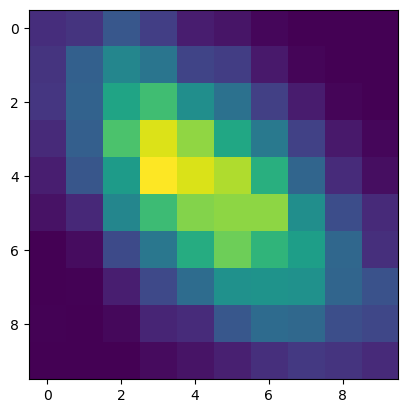

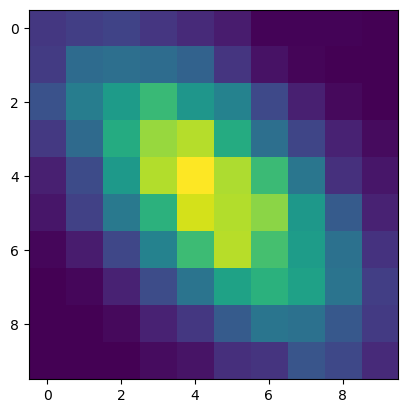

In [130]:
import matplotlib.pyplot as plt

plt.imshow(mean_shap_values3d)
plt.figure()
plt.imshow(coefs)
plt.show()